# 20220327-zoo-phases
- Phase behavior (per-trace, across simpoints)
    - IPC
    - MPKI
    
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from utils import utils, stats

In [2]:
data_path = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo.csv'
data_path_cs = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo_cloudsuite.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

df = utils.read_data_file(data_path)
df_cs = utils.read_data_file(data_path_cs)
df = df.append(df_cs)
weights = utils.read_weights_file(weight_path)

In [3]:
df[df.prefetcher == 'bingo_bo']

full_trace      trace simpoint prefetcher        degree   accuracy  \
0         astar_163B      astar     163B   bingo_bo  (None, None)  15.508980   
21         astar_23B      astar      23B   bingo_bo  (None, None)  30.396749   
42        astar_313B      astar     313B   bingo_bo  (None, None)   6.674550   
63               bfs        bfs  default   bingo_bo  (None, None)  37.361221   
84      bwaves_1609B     bwaves    1609B   bingo_bo  (None, None)  99.970884   
...              ...        ...      ...        ...           ...        ...   
1197  xalancbmk_768B  xalancbmk     768B   bingo_bo  (None, None)  58.547078   
1218   xalancbmk_99B  xalancbmk      99B   bingo_bo  (None, None)  23.194988   
1239     zeusmp_100B     zeusmp     100B   bingo_bo  (None, None)  86.416927   
1260     zeusmp_300B     zeusmp     300B   bingo_bo  (None, None)  81.001116   
1281     zeusmp_600B     zeusmp     600B   bingo_bo  (None, None)  97.866921   

       coverage       mpki  mpki_reduction  dram_bw_epochs  dram_bw_reduction  \
0     28.070636   0.987360       50.258942          384334           7.680815   
21    50.747833   1.165060       51.576086          718977          26.956689   
42     9.936301  34.046419       42.092410         1855199          -5.702539   
63    67.262308   1.615520       67.504244          449921          22.767636   
84    88.729246   2.565280       89.010976          223729          39.072453   
...         ...        ...             ...             ...                ...   
1197  55.146079   0.101020       56.089716          263689           6.397004   
1218  46.310260  11.626320       46.333556          694309           9.530157   
1239  36.006970   3.165620       51.947673          159805           6.052322   
1260  59.499110   1.087700       66.332374          157717          18.195728   
1281  91.408460   0.270960       92.561684          150407          21.051167   

          ipc  ipc_improvement baseline_prefetcher  \
0     0.53898         7.871510                  no   
21    0.28257        33.262592                  no   
42    0.10686        -6.090166                  no   
63    0.45728        27.025751                  no   
84    0.98056        72.025052                  no   
...       ...              ...                 ...   
1197  0.80751         7.133760                  no   
1218  0.28925        10.392336                  no   
1239  1.37572         7.105765                  no   
1260  1.40493        25.365183                  no   
1281  1.43958        29.488909                  no   

                                                   path  \
0     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
21    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
42    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
63    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
84    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
...                                                 ...   
1197  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
1218  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
1239  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
1260  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   
1281  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...   

                                          baseline_path  
0     /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
21    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
42    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
63    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
84    /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
...                                                 ...  
1197  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
1218  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
1239  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
1260  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  
1281  /scratch/cluster/cmolder/prefetcher_zoo/2022_0...  

[62 rows x 16 columns

In [4]:
weights

full_trace    weight            trace simpoint
0                astar_163B  0.452174            astar     163B
1                 astar_23B  0.162319            astar      23B
2                astar_313B  0.220290            astar     313B
3              bwaves_1609B  0.262524           bwaves    1609B
4              bwaves_1861B  0.337187           bwaves    1861B
..                      ...       ...              ...      ...
184  streaming_phase1_core3  0.166667  streaming_core3   phase1
185  streaming_phase2_core3  0.166667  streaming_core3   phase2
186  streaming_phase3_core3  0.166667  streaming_core3   phase3
187  streaming_phase4_core3  0.166666  streaming_core3   phase4
188  streaming_phase5_core3  0.166666  streaming_core3   phase5

[189 rows x 4 columns]

# Helper functions

In [163]:
def plot_phase_behavior(df, trace, metric, weights=None,
                        prefetchers=None,
                        ymin=None, ymax=None, dpi=None):
    
    df = df[df.trace == trace][['simpoint', 'prefetcher', metric]]
    
    # Get phase_combined prefetcher
    df_phase_combined = pd.DataFrame(columns=['simpoint', 'orig_prefetcher', 'prefetcher', metric])
    for sp in df.simpoint.unique():
        best = df.loc[df[df.simpoint == sp][metric].idxmax()].to_frame().T
        best['orig_prefetcher'] = best['prefetcher']
        df_phase_combined = df_phase_combined.append(best)
    
    df_phase_combined['prefetcher'] = 'phase_combined'
    df = df.append(df_phase_combined)

    # Filter prefetchers (if wanted)
    pf_list = prefetchers if prefetchers is not None else df.prefetcher.unique().tolist()
    pf_list = pf_list.copy()
    pf_list = pf_list + ['phase_combined']
    df = df[df.prefetcher.isin(pf_list)]
    
    sp_list = df.simpoint.unique()
    if len(sp_list) <= 1: # Don't plot phase behavior on single-simpoint benchmarks (e.g. GAP)
        return
    
    # Plot
    fig, ax = plt.subplots(dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    for pf in pf_list:
        X, y = [], []
        for i, sp in enumerate(sp_list):
            X.append(i)
            y.append(df[(df.prefetcher == pf) & (df.simpoint == sp)][metric].item())
            
        if pf == 'phase_combined':
            label, color, dash = 'phase_combined', 'blue', '.--'
        elif prefetchers is not None:
            label, color, dash = f'({pf_list.index(pf)+1}) {pf}', None, '.-'
        else:
            label, color, dash = pf, None, '.-'
        
        ax.plot(X, y, dash, label=label, color=color)
        
        # Add annotations for phase_combined with the name of
        # the best prefetcher in each phase.
        #
        # TODO - verify ordering is preserved
        if pf == 'phase_combined':
            for x_, y_, pf in zip(X, y, df[df.prefetcher == 'phase_combined']['orig_prefetcher'].to_list()):
                plt.annotate(pf, (x_, y_), color=color, ha='left', va='bottom')

    # Get tick labels
    if not weights.empty:
        sp_labels = []
        for sp in sp_list:
            weight = weights[(weights.trace == tr) & (weights.simpoint == sp)].weight.item()
            sp_labels.append(f'{sp}\n({weight*100:.1f}%)')
    else:
        sp_labels = sp_list
    
    fig.suptitle(f'{trace}: {metric} phase behavior')
    ax.set_xticks(range(0, len(sp_list)))
    ax.set_xticklabels(sp_labels)
    ax.set_xlabel('Simpoint (weight)')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    fig.tight_layout()

---
## SPEC '06 phase behavior
### Top 5

In [121]:
spec_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.spec)], 'ipc_improvement', 5)
spec_top_5

['sms_pythia', 'bingo_pythia', 'bingo_sms', 'sisb_pythia', 'bingo_sisb']

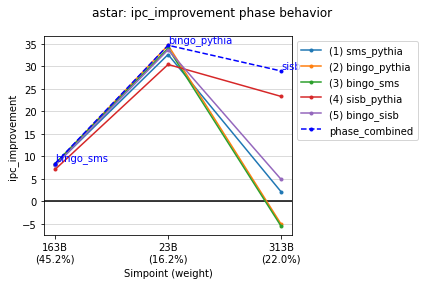

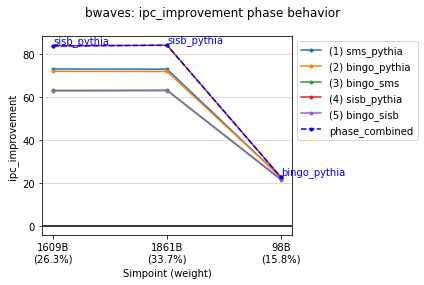

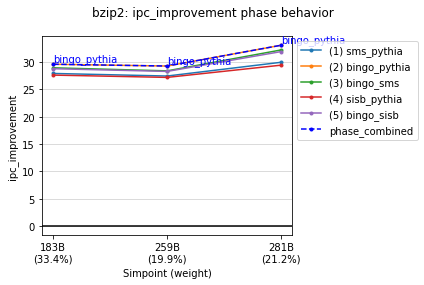

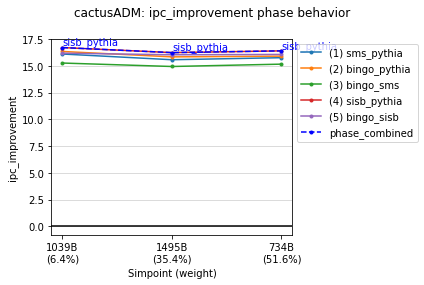

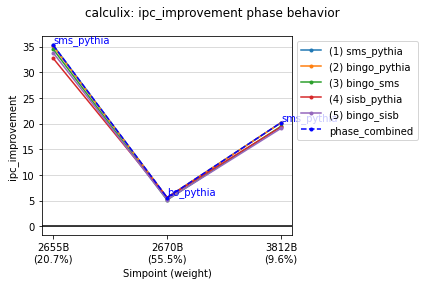

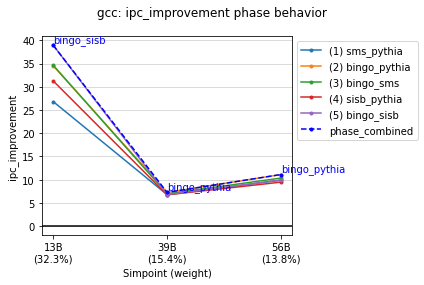

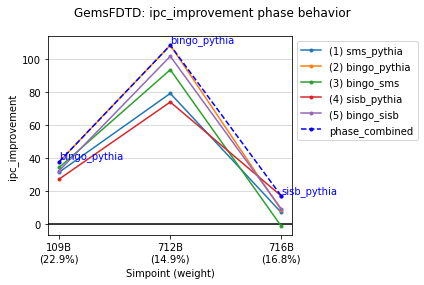

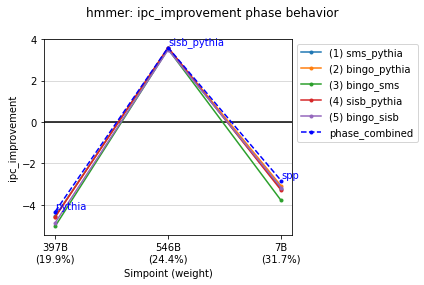

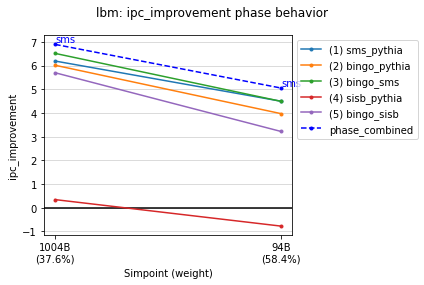

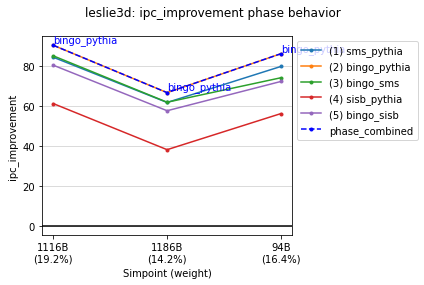

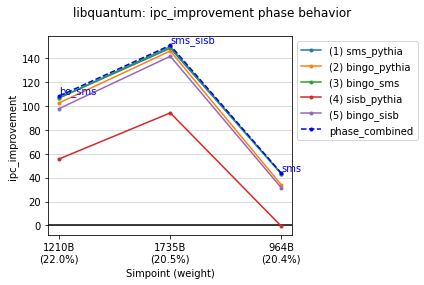

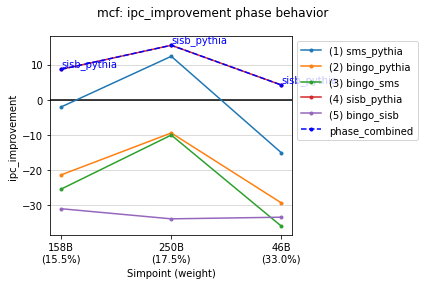

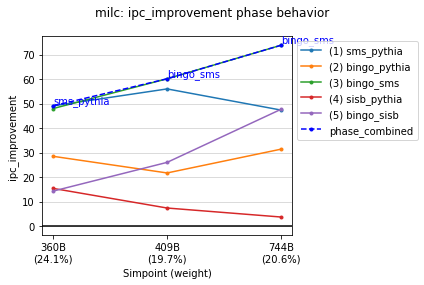

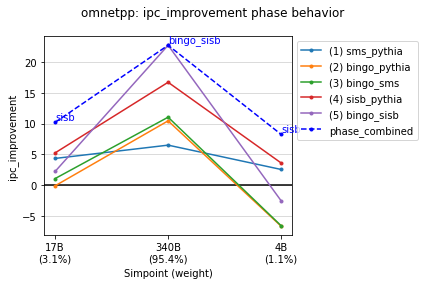

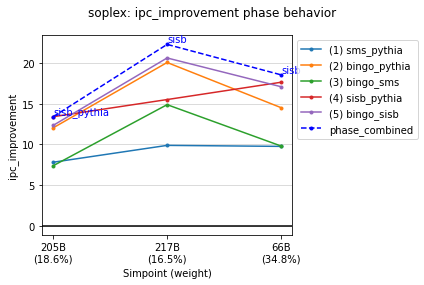

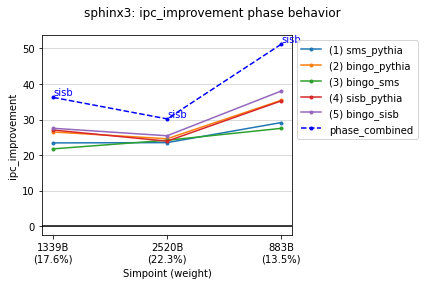

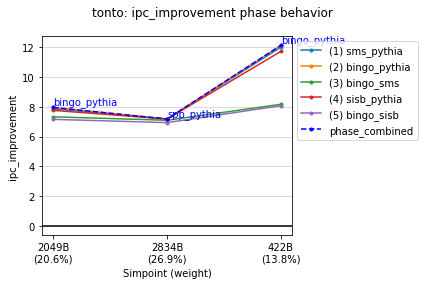

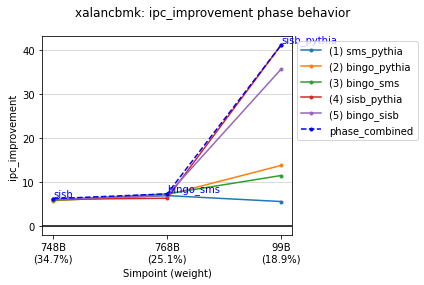

In [165]:
for tr in utils.spec:
    plot_phase_behavior(
        df, tr, 'ipc_improvement', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/ipc_improvement_5_{tr}.pdf')

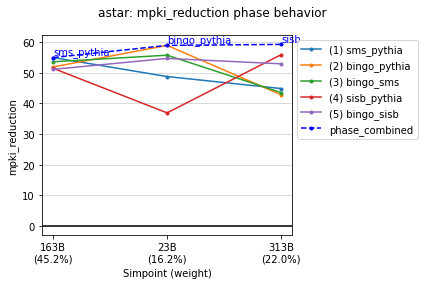

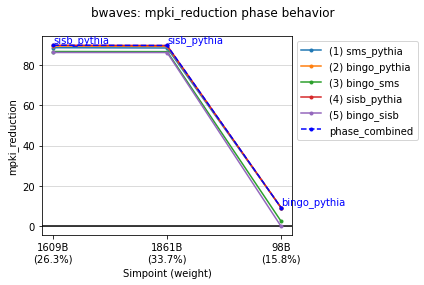

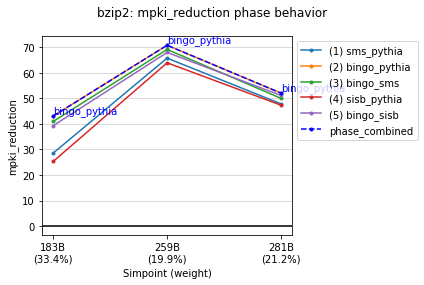

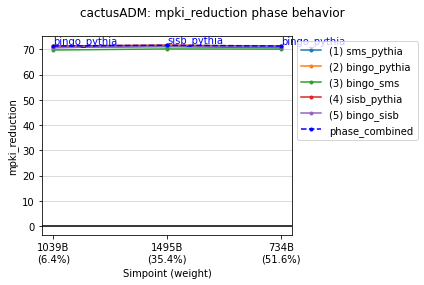

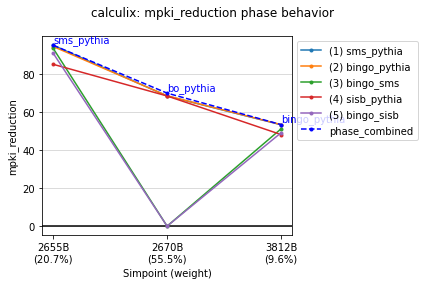

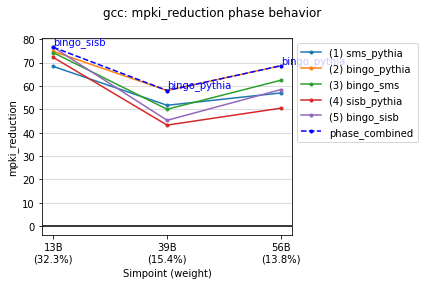

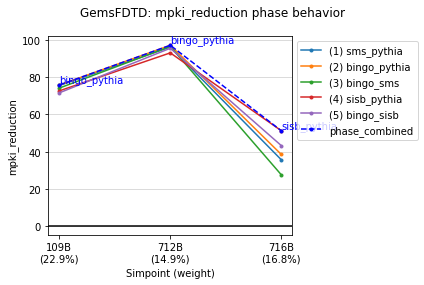

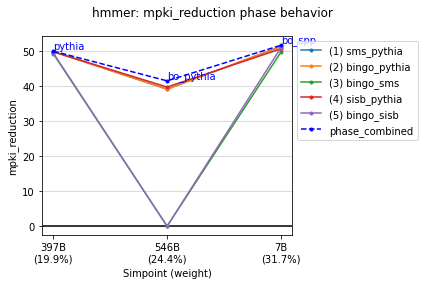

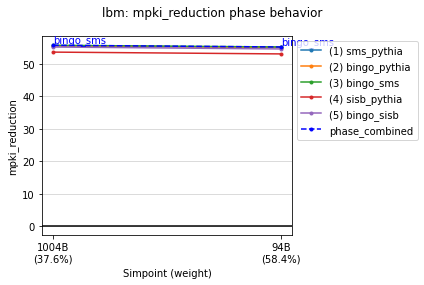

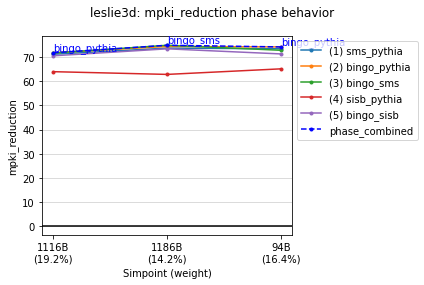

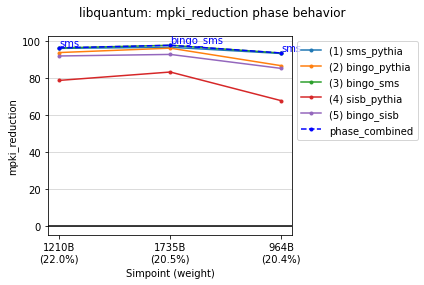

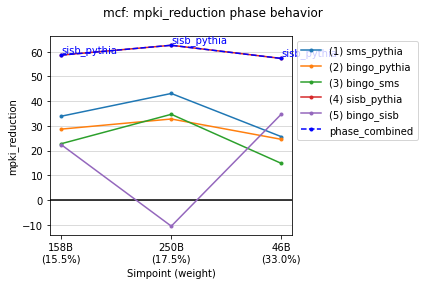

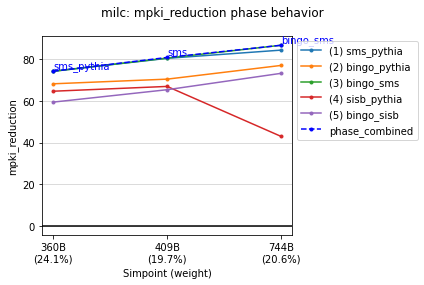

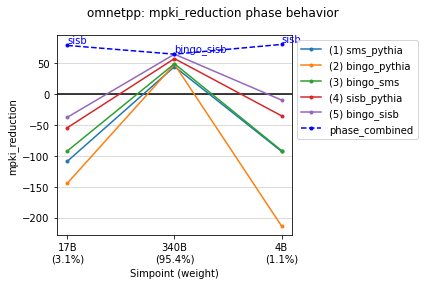

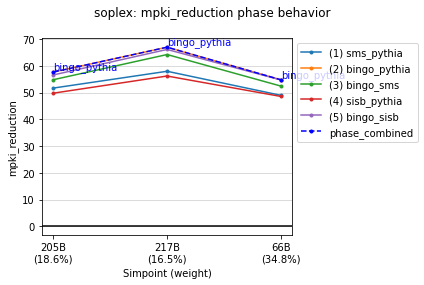

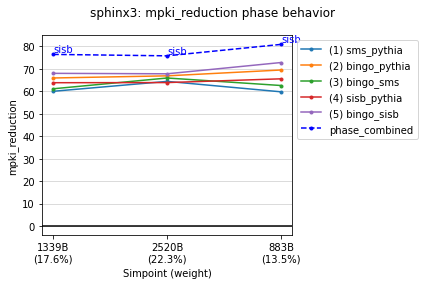

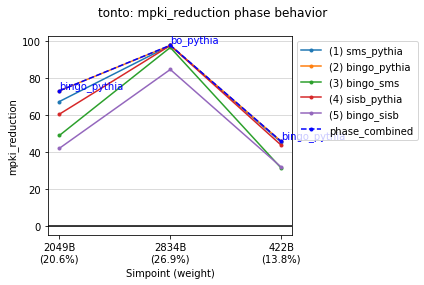

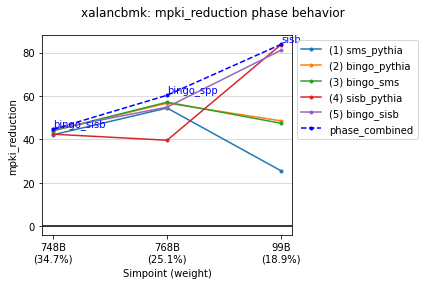

In [166]:
for tr in utils.spec:
    plot_phase_behavior(
        df, tr, 'mpki_reduction', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
        #ymin=-40, ymax=50
    )
    plt.savefig(f'plots/zoo-phases/mpki_reduction_5_{tr}.pdf')

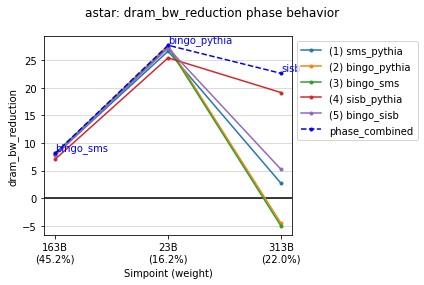

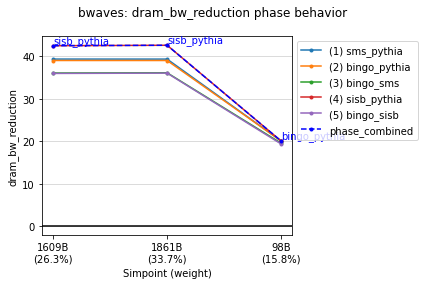

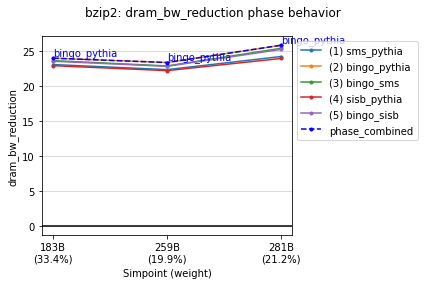

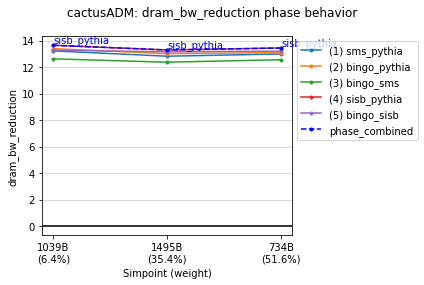

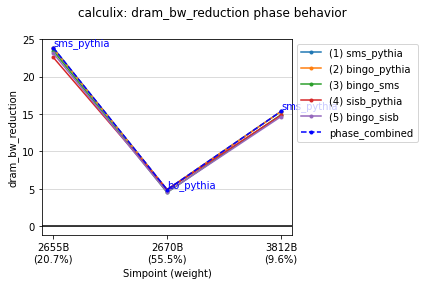

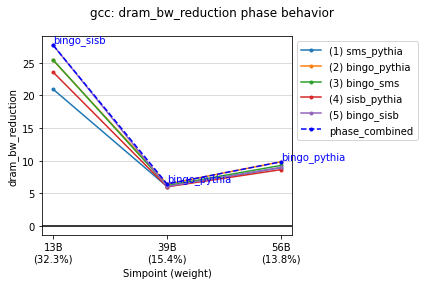

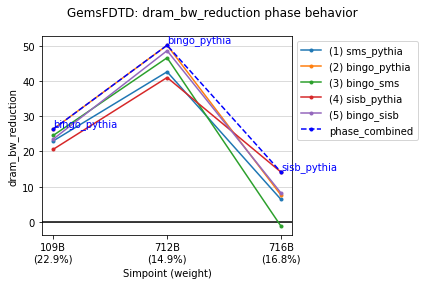

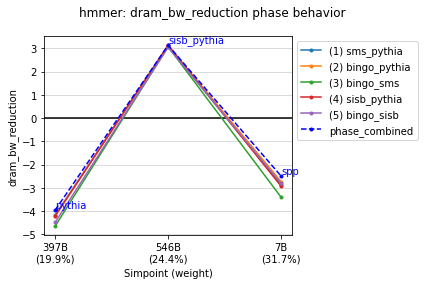

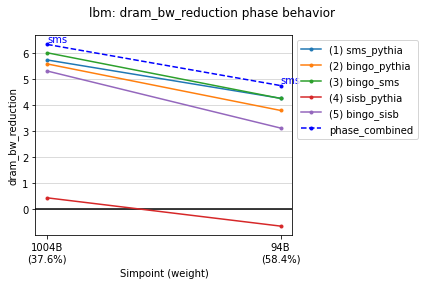

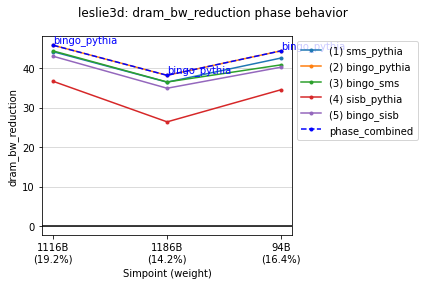

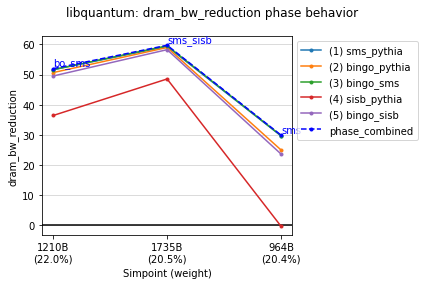

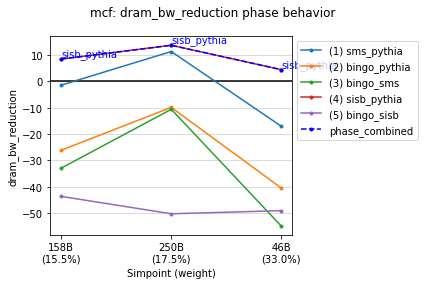

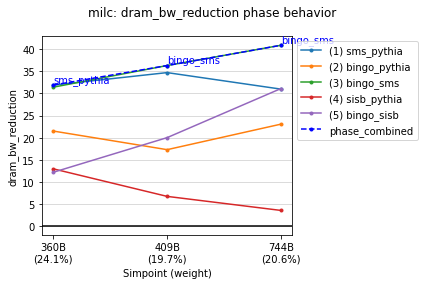

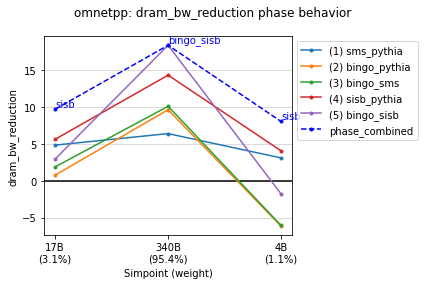

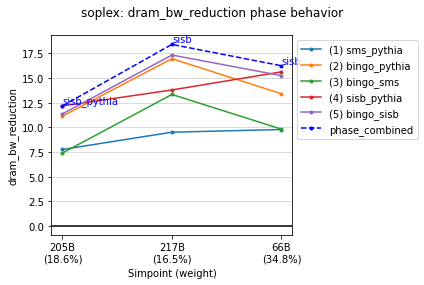

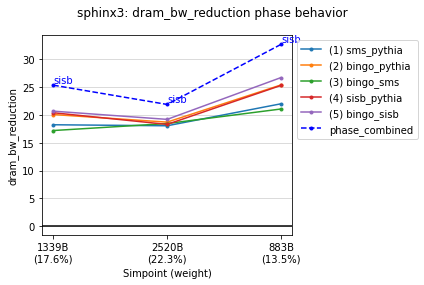

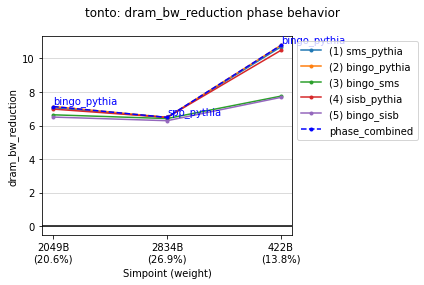

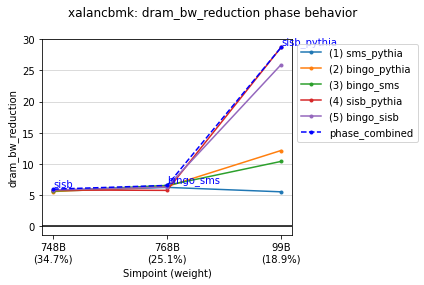

In [167]:
for tr in utils.spec:
    plot_phase_behavior(
        df, tr, 'dram_bw_reduction', weights=weights,
        prefetchers=spec_top_5,
        dpi=None,
        #ymin=-40, ymax=50
    )
    plt.savefig(f'plots/zoo-phases/dram_bw_reduction_5_{tr}.pdf')

---
## Cloudsuite phase behavior
## Top 5

In [168]:
cs_top_5 = utils.rank_prefetchers(df[df.trace.isin(utils.cloudsuite)], 'ipc_improvement', 5)
cs_top_5

['sisb_pythia', 'bingo_pythia', 'bingo_sisb', 'sms_pythia', 'bingo_spp']

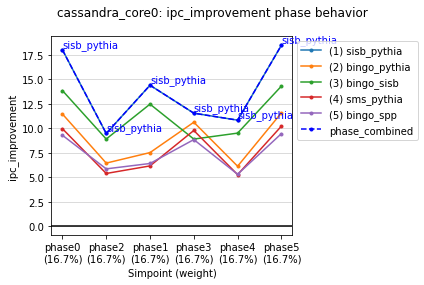

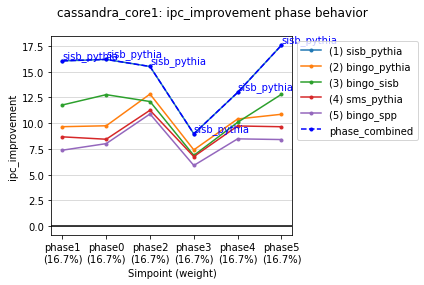

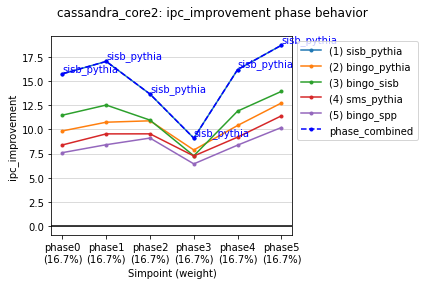

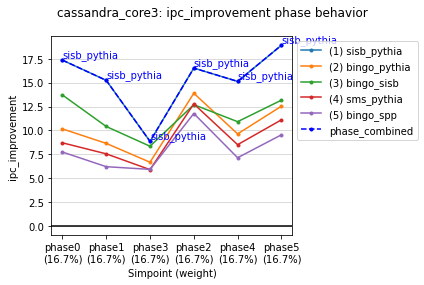

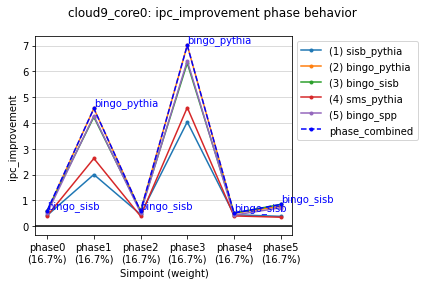

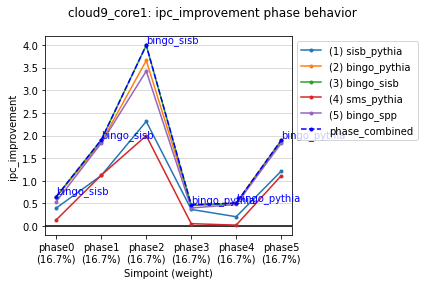

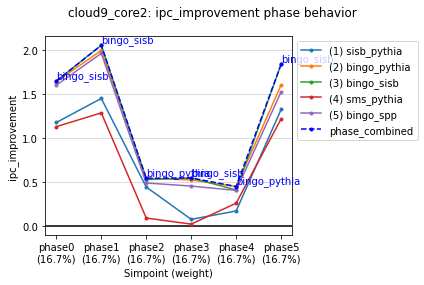

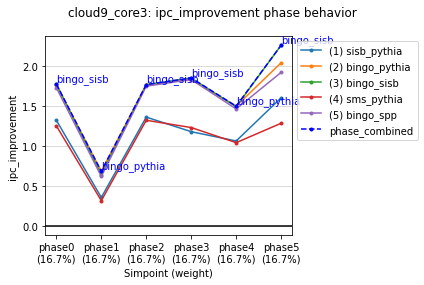

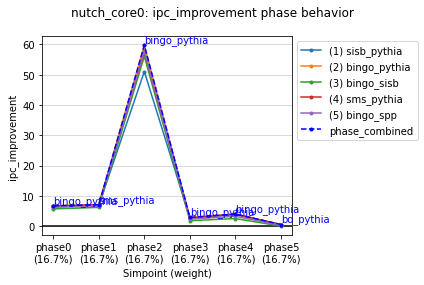

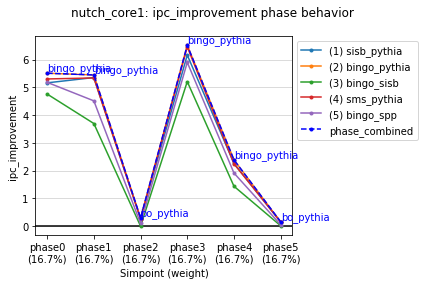

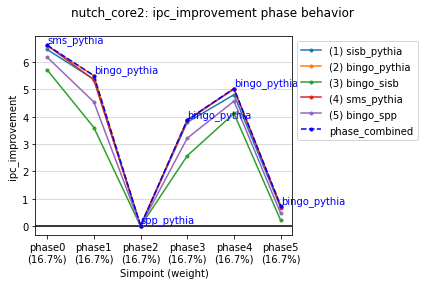

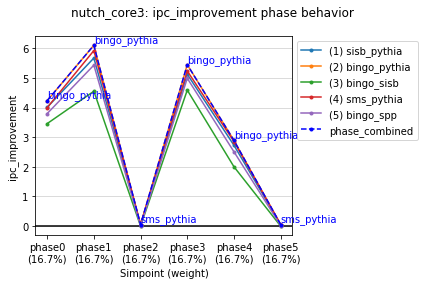

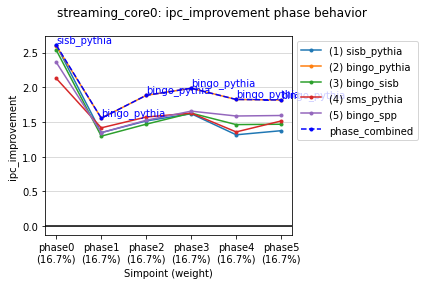

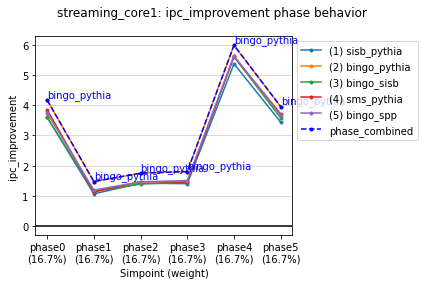

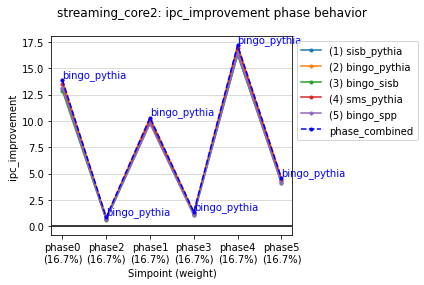

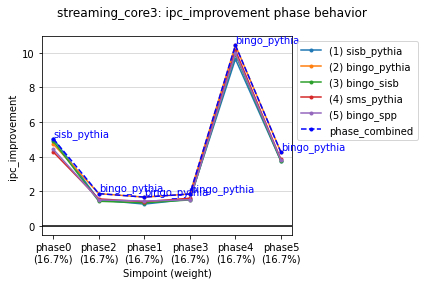

In [169]:
for tr in utils.cloudsuite:
    plot_phase_behavior(
        df, tr, 'ipc_improvement', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/ipc_improvement_5_{tr}.pdf')

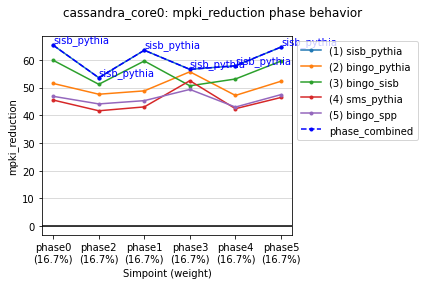

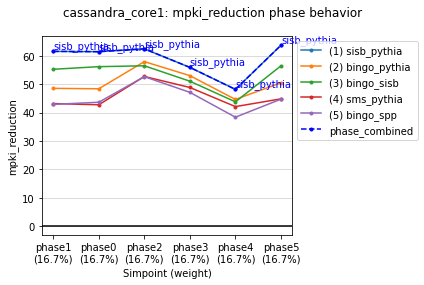

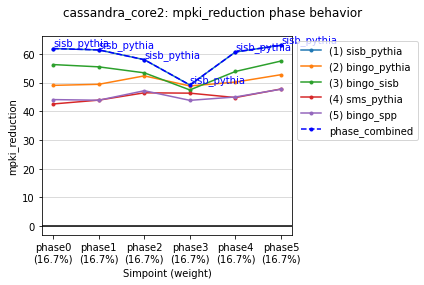

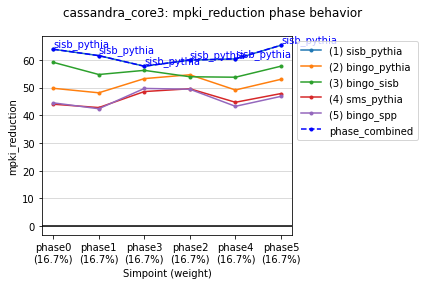

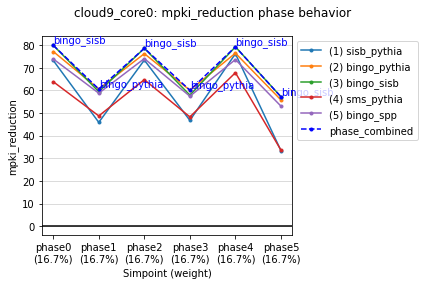

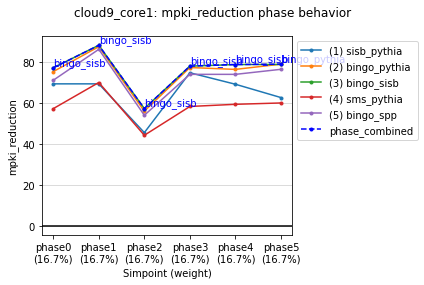

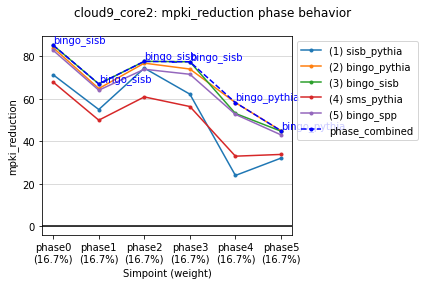

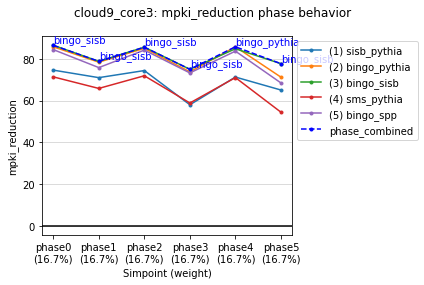

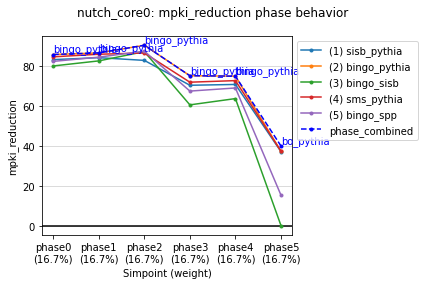

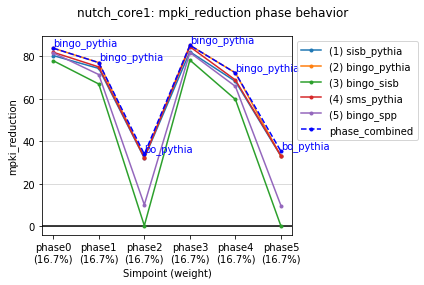

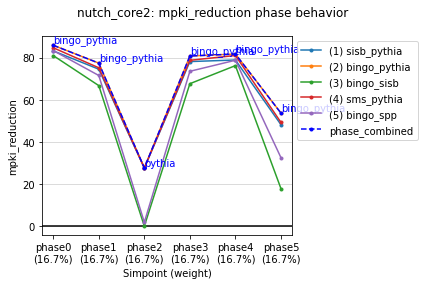

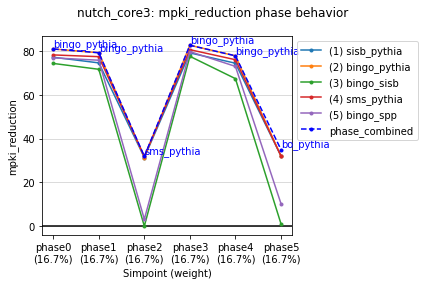

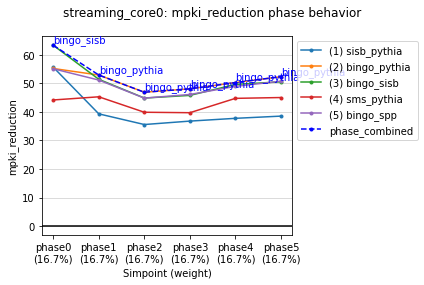

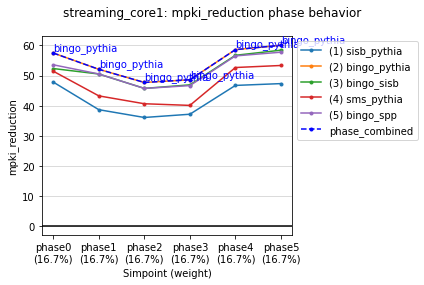

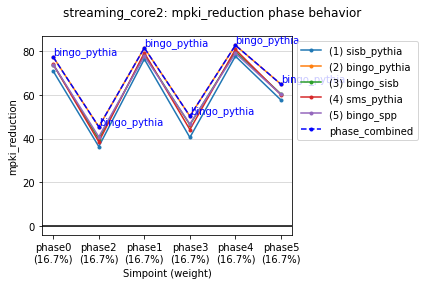

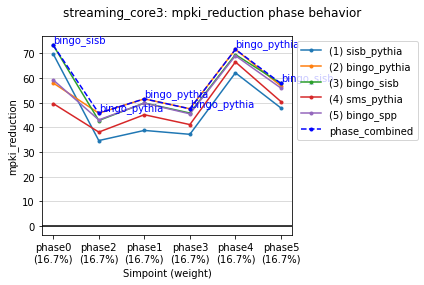

In [170]:
for tr in utils.cloudsuite:
    plot_phase_behavior(
        df, tr, 'mpki_reduction', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/mpki_reduction_5_{tr}.pdf')

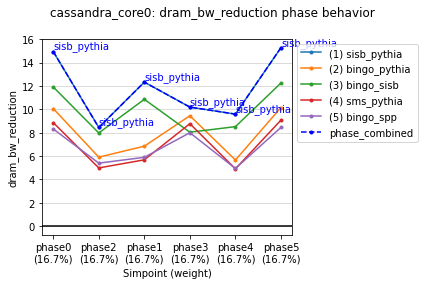

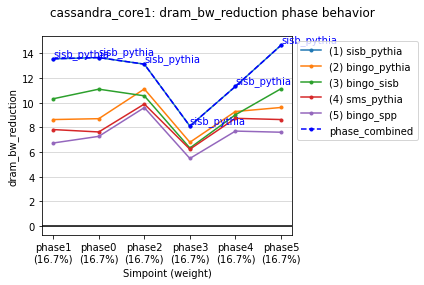

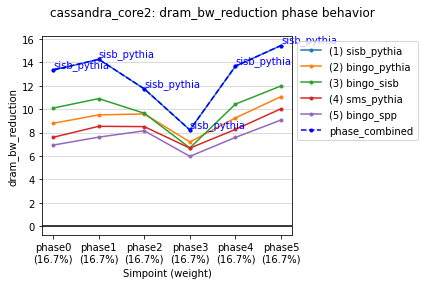

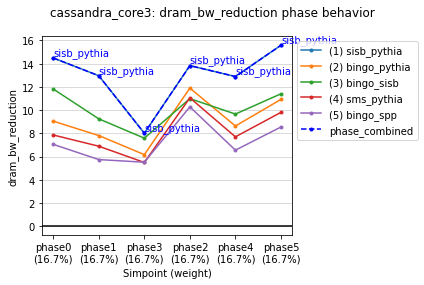

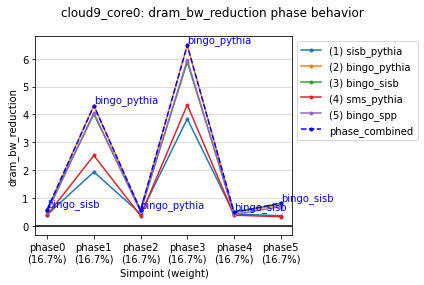

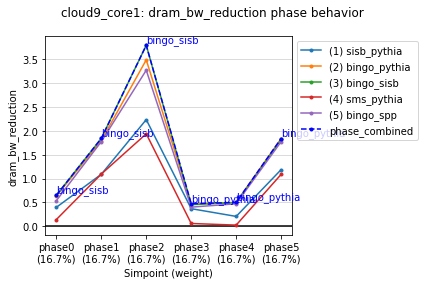

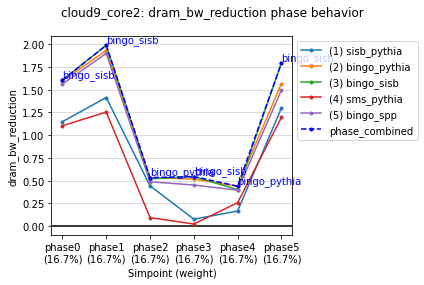

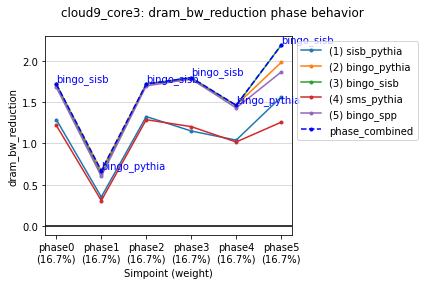

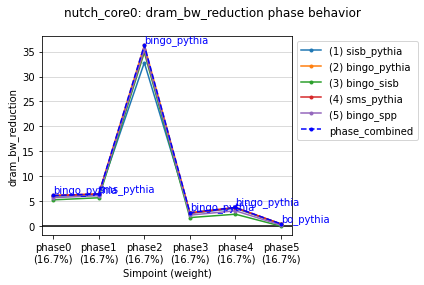

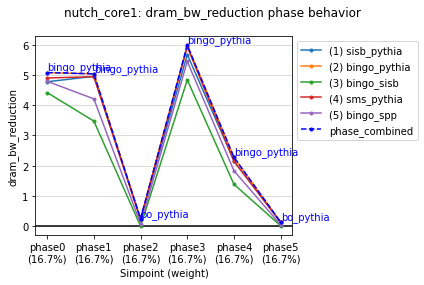

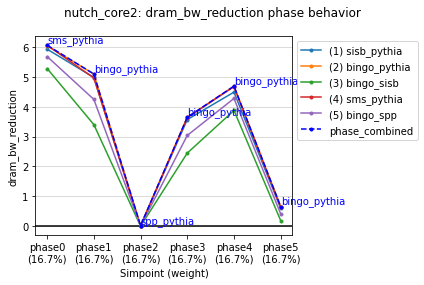

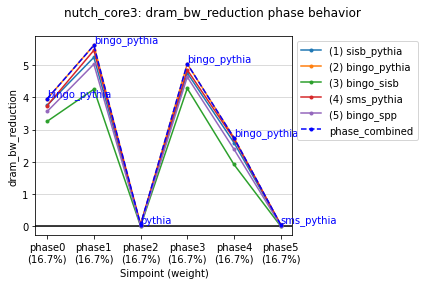

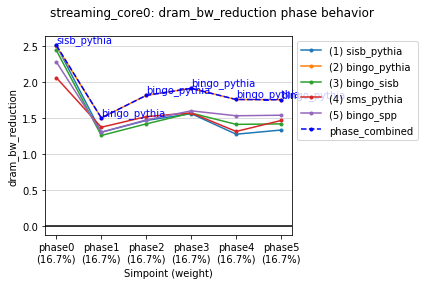

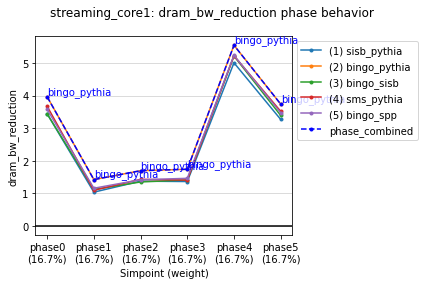

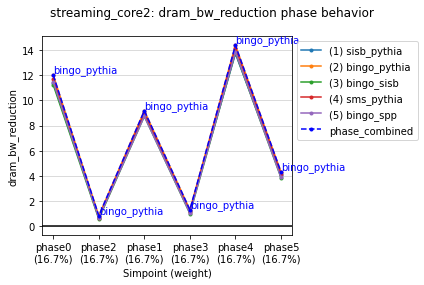

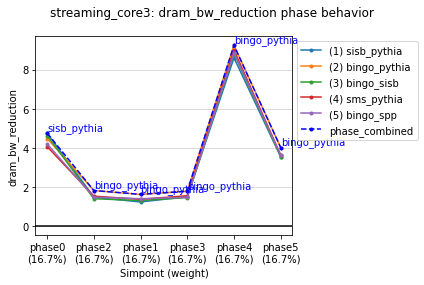

In [171]:
for tr in utils.cloudsuite:
    plot_phase_behavior(
        df, tr, 'dram_bw_reduction', weights=weights,
        prefetchers=cs_top_5,
        dpi=None,
    )
    plt.savefig(f'plots/zoo-phases/dram_bw_reduction_5_{tr}.pdf')